In [3]:
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.collections import LineCollection
import numpy as np
import h5py

plt.rcParams['animation.ffmpeg_path'] = r'C:\Users\ChemeGrad2019\Downloads\ffmpeg-2020-12-09-git-7777e5119a-full_build\bin\ffmpeg.exe'
ffmpeg_writer = animation.FFMpegWriter(fps=30, codec='libx265', extra_args=['-crf', '18'])

In [4]:
f = h5py.File('../output/julia_example_sims.h5', 'r')

In [6]:
max_rnap = 0
max_idx = 0
for idx, example in enumerate(f):
    if example['rnap_location'].shape[2] > max_rnap:
        max_rnap = example['rnap_location'].shape[2]
        max_idx = idx
print(max_rnap)
print(max_idx)

TypeError: string indices must be integers

In [10]:
examples=f['tangles_full_run.001151']
print(examples.attrs['comment'])
print(examples.attrs['rates.topo'])
print(examples.attrs['gene.base_rate'])
print(examples['time'].shape)

b'2_gene.divergent'
0.0008333333333333334
[0.00624912 0.00833333]
(10043,)


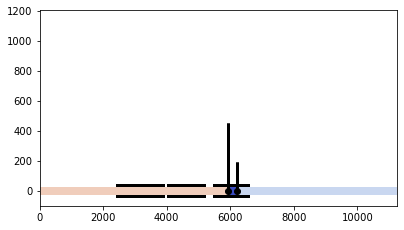

In [93]:
def gen_animation(data_group, gene_colors, filename, is_circular):
    fig, ax = plt.subplots(figsize=(1920 / 300,1080 / 300))

    genes = list(zip(data_group.attrs['gene.start'], data_group.attrs['gene.end']))


    max_length = data_group.attrs['bcs.length']
    ax.set_xlim([0,max_length])
    ax.set_ylim([-100, 100 + max([abs(gene[1] - gene[0]) for gene in genes])])

    polymerases = ax.plot([], [], 'ko')[0]

    gene_plots = [ax.plot(gene, [0, 0], 'k',linewidth=14, zorder=0)[0] for gene in genes]

    main_line = LineCollection([], cmap=plt.cm.coolwarm, norm=plt.Normalize(-.2,.2))
    mRNA_lines = LineCollection([], colors='k')

    def init():
        main_line.set_segments([])
        main_line.set_linewidth(8)
        mRNA_lines.set_linewidth(3)
        ax.add_collection(main_line)
        ax.add_collection(mRNA_lines)
        return (*gene_plots, main_line, mRNA_lines)
    
    def animate(i):
        n_polymerases = np.sum(data_group['rnap_location'][:,i] >= 0)
        rnap_locs = np.concatenate((
            np.zeros(1,),
            data_group['rnap_location'][:n_polymerases,i],
            np.ones(1,) * max_length
        ))
        rnap_masked = np.ma.masked_array(rnap_locs[1:-1], mask=rnap_locs[1:-1] < 0)
        phi = np.concatenate((
            np.zeros(1,),
            data_group['phi'][:n_polymerases,i],
            np.zeros(1,)
        ))
        sigma = np.diff(phi) / np.diff(rnap_locs) / -1.85
        points = np.array([rnap_locs, np.zeros(rnap_locs.shape)]).T.reshape(-1,1,2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        main_line.set_segments(segments)
        main_line.set_array(sigma)

        polymerases.set_data(rnap_masked, np.zeros(rnap_masked.shape))

        mRNA_base = np.array([rnap_locs[1:  -1], np.zeros(rnap_locs[1:-1].shape)]).T.reshape(-1,1,2)
        mRNA_tail = np.array([rnap_locs[1:-1], data_group['mRNA_length'][:n_polymerases,i]]).T.reshape(-1,1,2)
        #print(mRNA_base)
        #print(mRNA_tail)
        mRNA_segments = np.concatenate([mRNA_base, mRNA_tail], axis=1)
        mRNA_lines.set_segments(mRNA_segments)


        return main_line, polymerases, mRNA_lines
    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=2000, interval=33, blit=True)
    anim.save(filename, dpi=300, writer=ffmpeg_writer)
gen_animation(examples, [], '../output/test_out.mp4', False)

In [31]:
   fig, axs = plt.subplots(1, 2, figsize=(10, 3), gridspec_kw={'width_ratios': [2, 1]})
       
    # Locate which raw segment this frame is in
    lookup_results =  np.where([np.any(r[0] <= time) & np.any(r[0] >= time) for r in run_result['raw']])
       
    excess_twist = multi_interp(time, run_result['time'], run_result['excess_twist'])
    sc_density = multi_interp(time, run_result['time'], run_result['sc_density'])

    x_domain = run_result['x_domain']
        
    # Plot genes
    for gene in genes:
        axs[0].plot([gene[0], gene[1]], [0, 0],
                linewidth=20, alpha=.5, zorder=1)

    # Plot DNA segments
    domain_points = np.array([x_domain, np.zeros(x_domain.shape)]).T.reshape(-1,1,2)
    segments = np.concatenate([domain_points[:-1], domain_points[1:]], axis=1)
    max_excursion = np.max(np.abs([np.min(run_result['sc_density']), np.max(run_result['sc_density'])]))
    cmap_norm = plt.Normalize(-.125, .125)
    dna_segments = LineCollection(segments, cmap='Spectral', norm=cmap_norm)
    dna_segments.set_array(sc_density)
    dna_segments.set_linewidth(8)
    line = axs[0].add_collection(dna_segments)
    fig.colorbar(line, ax=axs[0])

bcs.is_circular
bcs.left_free
bcs.length
bcs.right_free
comment
gene.base_rate
gene.end
gene.start
rates.mRNA_degradation
rates.topo
b'2_gene.tandem'


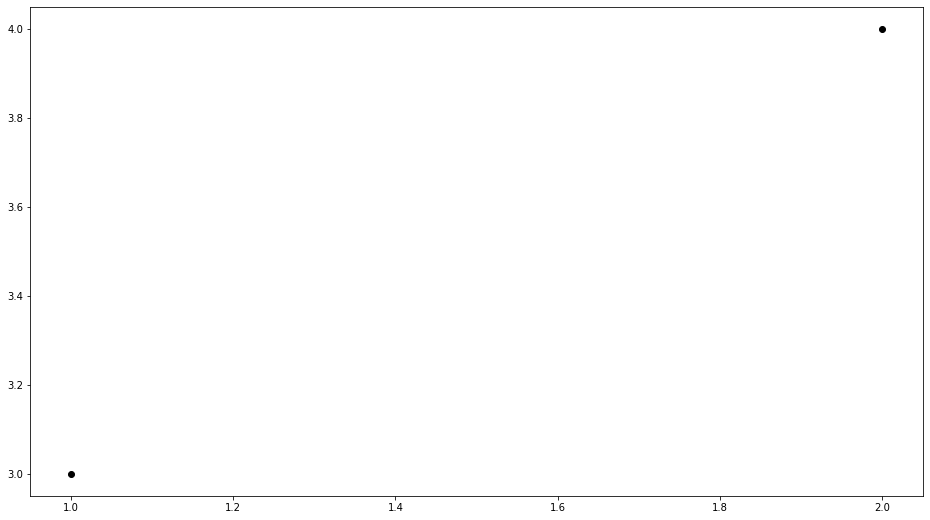

In [38]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot([1,2],[3,4], 'ko')

In [41]:
print(examples['phi'][:, 180])

[921.0357003  -1.         -1.         -1.       ]


In [42]:
print(examples.keys())

<KeysViewHDF5 ['mRNA_length', 'phi', 'rnap_location', 'time']>
